# Acknowledgements

Original Kernel: https://www.kaggle.com/barnrang/ashrae-leak-validation-gradient-descent-search

# All we need is Leak Validation(LV) ?

* **if you like this kernel, please upvote original kernels.**
* update site-4 and site-15
* Turn GPU on for better performance

this kernel is still work in progress, but i hope you can find something usefull from this.

In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
# import xgboost as xgb
# import catboost as cb
import tensorflow as tf

from sklearn.metrics import mean_squared_error
import feather

# Load data

In [2]:
%%time
test = feather.read_dataframe('../data/Prepared_data/test_filled_na_light.feather')
leaked = feather.read_dataframe('../data/Leaked/leaked_submission.feather')
leaked.set_index('row_id',inplace=True)
test.set_index('row_id',inplace=True)

CPU times: user 12.6 s, sys: 29.2 s, total: 41.7 s
Wall time: 1min 12s


In [38]:
submission_files_list = ['../data/kaggler_submission/submission_1.csv',
                         '../data/kaggler_submission/submission_2.csv',
                         '../data/kaggler_submission/submission_3.csv',
                         '../data/submission/submission_v18.csv',
                         '../data/submission/submission_v37.csv',
                         '../data/submission/submission_v40.csv',
                         '../data/submission/submission_v41.csv',
                         '../data/submission/submission_stack.csv',
                         '../data/submission/submission_blend_1_bis.csv',
                         '../data/kaggler_submission/submission_4.csv',
                        ] 

# submission_files_list = [
#                          '../data/submission/submission_blend_2.csv',
#                          '../data/submission/submission_blend_4.csv',
#                          '../data/submission/submission_blend_5.csv',
#                          '../data/submission/submission_blend_8.csv',
#                         ] 

n_pred = len(submission_files_list)
i = 0
for f in submission_files_list:
    i += 1
    sample_submission = pd.read_csv(f)
    sample_submission.set_index('row_id',inplace=True)
    test[f'pred{i}'] = sample_submission['meter_reading']

del sample_submission

In [39]:
for i in range(n_pred):
    test[f'pred{i+1}_l1p'] = np.log1p(test[f'pred{i+1}'])

gc.collect()

test.sort_index(inplace=True)

# Leak Validation for public kernels(not used leak data)

In [52]:
test_leaked = test.loc[leaked.index].copy()
test_leaked['meter_reading'] = leaked['meter_reading']
test_leaked['meter_reading_l1p'] = np.log1p(test_leaked.meter_reading)
print(test_leaked.shape)
test_leaked = test_leaked[test_leaked['meter_reading_l1p'].gt(0) | test_leaked['meter'].ne(0)].copy()
print(test_leaked.shape)
gc.collect()

(11937501, 85)
(11824695, 85)


56

Filter rows that have unlikely values

In [53]:
grouping = test_leaked['building_id'].astype(str) +'_'+\
             test_leaked['utc_time'].dt.month.astype(str) +'_'+\
             test_leaked['meter'].astype(str) 

temp_df = test_leaked.groupby(grouping)['meter_reading'].apply(lambda x: int(np.percentile(x,99)))
temp_df = temp_df.to_dict()

modified_meter_reading = grouping.map(temp_df)

test_leaked = test_leaked[test_leaked['meter_reading'].lt(modified_meter_reading)]

Remove 0 values for meter 0 

In [54]:
test_leaked = test_leaked[test_leaked['meter_reading_l1p'].gt(0) | test_leaked['meter'].ne(0)].copy()

Remove buildings with most errors in each meter type

In [55]:
buildings_to_filter = []
for m in range(4):
    buildings_to_filter.append(pd.read_csv(f'../data/Leaked/leaked_filter_buildings_meter_{m}.csv'))

buildings_to_filter = pd.concat(buildings_to_filter,axis=0).reset_index(drop=True)

for i in buildings_to_filter.index:
    print(f'\n{i}')
    b = buildings_to_filter.loc[i,'building_id']
    m = buildings_to_filter.loc[i,'meter']
    print(test_leaked.shape)
    test_leaked = test_leaked[test_leaked['building_id'].ne(b) | test_leaked['meter'].ne(m)]
    print(test_leaked.shape)



0
(11421270, 85)
(11404444, 85)

1
(11404444, 85)
(11399467, 85)

2
(11399467, 85)
(11382172, 85)

3
(11382172, 85)
(11364885, 85)

4
(11364885, 85)
(11347663, 85)

5
(11347663, 85)
(11334018, 85)

6
(11334018, 85)
(11318161, 85)

7
(11318161, 85)
(11300835, 85)

8
(11300835, 85)
(11286312, 85)

9
(11286312, 85)
(11268984, 85)

10
(11268984, 85)
(11251660, 85)

11
(11251660, 85)
(11234326, 85)

12
(11234326, 85)
(11216992, 85)

13
(11216992, 85)
(11199658, 85)

14
(11199658, 85)
(11182328, 85)

15
(11182328, 85)
(11169223, 85)

16
(11169223, 85)
(11152005, 85)

17
(11152005, 85)
(11134810, 85)

18
(11134810, 85)
(11119116, 85)

19
(11119116, 85)
(11102138, 85)

20
(11102138, 85)
(11085272, 85)

21
(11085272, 85)
(11072320, 85)

22
(11072320, 85)
(11056489, 85)

23
(11056489, 85)
(11040436, 85)

24
(11040436, 85)
(11023245, 85)

25
(11023245, 85)
(11006156, 85)

26
(11006156, 85)
(10990470, 85)


#### Plot distributions for each prediction

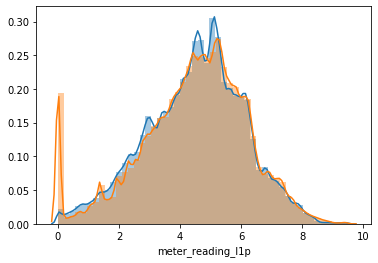

score 1= 0.7233721548730748


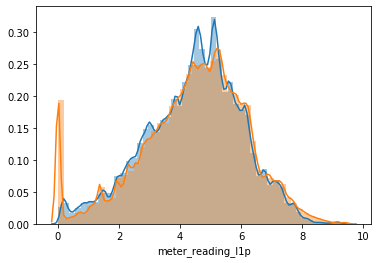

score 2= 0.7457004380230513


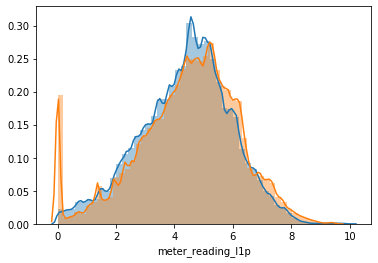

score 3= 0.7891644938373744


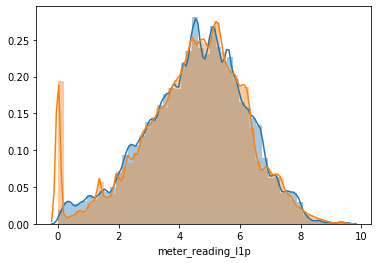

score 4= 0.7814779544978224


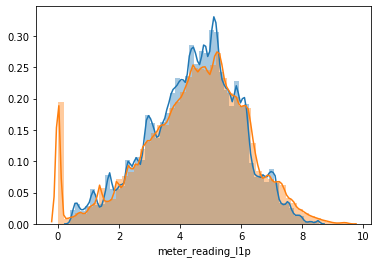

score 5= 0.7434290858427363


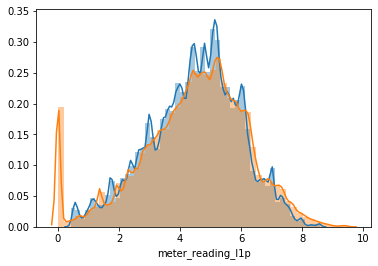

score 6= 0.7483655526021981


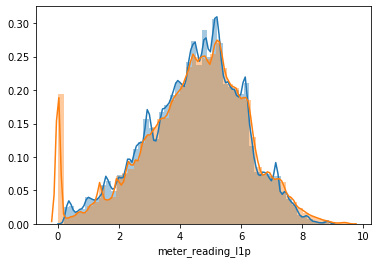

score 7= 0.7263448654307001


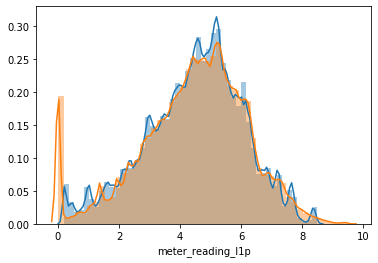

score 8= 0.7066425915139664


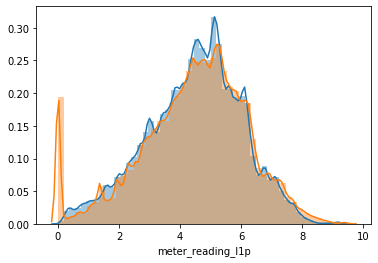

score 9= 0.7012090476242936


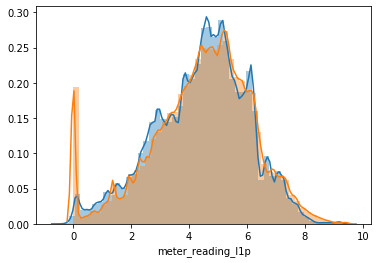

score 10= 0.7627637499730259


In [56]:
for i in range(n_pred):
    sns.distplot(test_leaked[f'pred{i+1}_l1p'])
    sns.distplot(test_leaked['meter_reading_l1p'])
    plt.show()

    leak_score = np.sqrt(mean_squared_error(test_leaked[f'pred{i+1}_l1p'], test_leaked['meter_reading_l1p']))
    print (f'score {i+1}=', leak_score)

# Leak Validation for Blending

A one idea how we can use LV usefull is blending. We probably can find best blending method without LB probing and it's means we can save our submission.

mean score= 0.7041880124918564


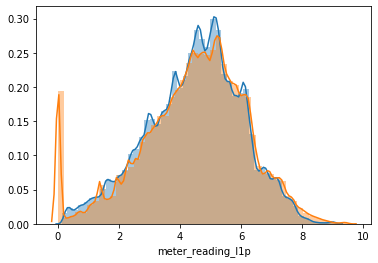

In [57]:
test_leaked['mean_pred_l1p'] = np.mean(test_leaked[[f'pred{i+1}_l1p' for i in range(n_pred)]].values, axis=1)
test_leaked['mean_pred'] = np.expm1(test_leaked['mean_pred_l1p'])
leak_score = np.sqrt(mean_squared_error(test_leaked['mean_pred_l1p'], test_leaked['meter_reading_l1p']))


sns.distplot(test_leaked['mean_pred_l1p'])
sns.distplot(test_leaked['meter_reading_l1p'])

print ('mean score=', leak_score)

meadian score= 0.6993529569670642


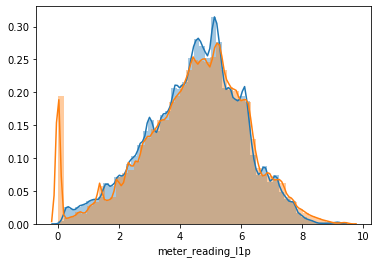

In [58]:
test_leaked['median_pred_l1p'] = np.median(test_leaked[[f'pred{i+1}_l1p' for i in range(n_pred)]].values, axis=1)
test_leaked['median_pred'] = np.expm1(test_leaked['median_pred_l1p'])
leak_score = np.sqrt(mean_squared_error(test_leaked['median_pred_l1p'], test_leaked['meter_reading_l1p']))

sns.distplot(test_leaked['median_pred_l1p'])
sns.distplot(test_leaked['meter_reading_l1p'])

print ('meadian score=', leak_score)

Ummm... it looks mean blending is beter than median blending

# Combination Search by using gradient descent

$x$ \- input 

$y$ \- target

$w$ \- weights

Let $f(x)=w^\top x$, we want to minimize

$$L(x,y)=(\log(f(x)+1)-\log(y+1))^2$$

Choose type of optimization : optimize with the raw values or log values ? Log sounds more reasonable but doesn't perform as well in LB...

In [59]:
log_optim = True

if log_optim:
    X_train = np.array(test_leaked[[f'pred{i+1}_l1p' for i in range(n_pred)]].values)
else :
    X_train = np.array(test_leaked[[f'pred{i+1}' for i in range(n_pred)]].values)
    
y_train = test_leaked.meter_reading_l1p

weight = np.float64(1/n_pred)
weights = tf.Variable([[weight]]*n_pred)

steps = 1000
lr = 0.1
weights_history = []
prev_loss = 9999

opt = tf.optimizers.SGD(lr)
zeros = tf.constant(np.zeros(y_train.shape))

In [60]:
# Speed up the train step by precompiling
if log_optim:
    @tf.function()
    def train_step(opt):
        with tf.GradientTape() as tape:
            y = tf.matmul(X_train, weights)[:,0]
            loss = tf.reduce_mean((y - y_train) ** 2)
        grads = tape.gradient(loss, weights)
        opt.apply_gradients([(grads, weights)])

        return loss
else:
    @tf.function()
    def train_step(opt):
        with tf.GradientTape() as tape:
            y = tf.matmul(X_train, weights)[:,0]
            y = tf.where(tf.less(y, zeros), zeros, y)
            loss = tf.reduce_mean((tf.math.log1p(y) - y_train) ** 2)
        grads = tape.gradient(loss, weights)
        opt.apply_gradients([(grads, weights)])

        return loss

In [61]:
for i in range(steps):
    loss = train_step(opt)
    if loss is None : 
        break
    if loss > prev_loss:
        lr /= 2
        opt.lr = lr
        
    prev_loss = loss
    if i % 50 ==0 :
        weights_history.append((i,weights.numpy()))
        print(f'step: {i} {np.sqrt(loss.numpy())}')   

step: 0 0.7041880124918561
step: 50 0.7032634515057495
step: 100 0.7030838239490892
step: 150 0.7029093361840957
step: 200 0.7027397193619972
step: 250 0.7025747228413339
step: 300 0.7024141128631326
step: 350 0.7022576713237498
step: 400 0.7021051946382277
step: 450 0.7019564926875156
step: 500 0.7018113878433937
step: 550 0.7016697140653797
step: 600 0.7015313160643157
step: 650 0.7013960485277164
step: 700 0.7012637754023185
step: 750 0.7011343692296067
step: 800 0.7010077105303966
step: 850 0.7008836872348458
step: 900 0.7007621941545293
step: 950 0.7006431324934616


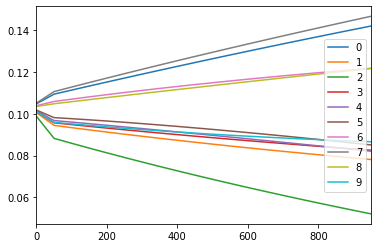

In [62]:
weights_history_df = pd.DataFrame([weights_history[i][1][:,0] for i in range(len(weights_history))],
                                  index=[weights_history[i][0] for i in range(len(weights_history))])
weights_history_df.plot()
plt.show()

In [63]:
# MSE
np.sqrt(loss)

0.700528721512834

In [ ]:
# # Created with all leaked non log - blend 2
# weights = [[ 0.06757527],
#        [ 0.39231985],
#        [ 0.05361557],
#        [ 0.04885705],
#        [ 0.18769572],
#        [-0.60393359],
#        [ 0.74815658]]

# # Created with strictly positive meter_reading leaked non log 
# weights = [[ 0.70626959],
#        [-0.17906121],
#        [-0.01257037],
#        [ 0.02890073],
#        [ 0.16743093],
#        [-0.0788699 ],
#        [ 0.38192729]]

# # Created with all leaked log - blend 3
# weights = [[0.25882326],
#        [0.14791705],
#        [0.10582719],
#        [0.16513024],
#        [0.0949991 ],
#        [0.02794446],
#        [0.17990342

# Created with all leaks non log + stack - blend 4
#        [[ 0.10545135],
#        [ 0.17434821],
#        [ 0.04530371],
#        [-0.00327071],
#        [ 0.14614418],
#        [-0.40105971],
#        [ 0.35979299],
#        [ 0.47060897]]

# Created with all leaks non log + stack + blend 1_bis (median) - blend 5
#        [[ 0.06897103],
#        [ 0.06418173],
#        [-0.01282486],
#        [-0.00603733],
#        [ 0.00504094],
#        [-0.27315875],
#        [ 0.21607463],
#        [ 0.35585292],
#        [ 0.4802837 ]]

# Created with filtering (meter_reading=0 for meter=0) leaks LOG + stack + blend 1_bis (median)  - blend 6 
#        [[ 0.11022942],
#        [ 0.0527467 ],
#        [-0.06858739],
#        [-0.00222164],
#        [-0.01271647],
#        [-0.2755586 ],
#        [ 0.20668246],
#        [ 0.38685019],
#        [ 0.53377629]]

# Created with ALL leaks LOG + stack + blend 1_bis (median)  - blend 7
#      [[ 0.06909906],
#       [ 0.06492939],
#       [-0.01278009],
#       [-0.00606041],
#       [ 0.00526145],
#       [-0.27211476],
#       [ 0.21469355],
#       [ 0.35685535],
#       [ 0.47851803]]

# Created with ALL leaks LOG + stack + blend 1_bis (median) + submission_4  - blend 8 (overwrote)
#     [[ 0.08150216],
#       [ 0.06227238],
#       [-0.02810843],
#       [-0.0070165 ],
#       [ 0.01661051],
#       [-0.21091868],
#       [ 0.14839356],
#       [ 0.36950876],
#       [ 0.37428139],
#       [ 0.09171797]]


# Blend 9 
#       [[0.04589263],
#        [0.11993479],
#        [0.43537573],
#        [0.39938709]]

# Blend 11
#      [[0.23741916],
#       [0.24496292],
#       [0.2595653 ],
#       [0.25766633]]

# Blend 12 : remove 0 for meter 0 and remove buildings which 
# had high errors due to (unpredictable) change in behavior 
# [[0.01052048],
#        [0.09808933],
#        [0.46525784],
#        [0.47373184]]

# Blend 13 : remove 0 for meter 0 and remove buildings which 
# had high errors due to (unpredictable) change in behavior 
# [[0.2378162 ],
       # [0.2456755 ],
       # [0.26266263],
       # [0.26279922]]

# Blend 14 : 
    # [[0.14371415],
    #    [0.07737053],
    #    [0.05040998],
    #    [0.08194033],
    #    [0.08124785],
    #    [0.08420535],
    #    [0.1224573 ],
    #    [0.14854131],
    #    [0.12262282],
    #    [0.08632779]]

# Submit

In [64]:
weights = weights.numpy()

In [66]:
weights.sum()

0.9988374164603775

In [67]:
if log_optim: 
    X_train = np.array(test[[f'pred{i+1}_l1p' for i in range(n_pred)]].values)
    test['meter_reading'] = np.matmul(X_train, weights)[:,0]
    test['meter_reading'] = np.expm1(test['meter_reading'])
else:
    X_train = np.array(test[[f'pred{i+1}' for i in range(n_pred)]].values)
    test['meter_reading'] = np.matmul(X_train, weights)[:,0]

test['meter_reading'] = np.where(test['meter_reading'].gt(0),test['meter_reading'],0)

In [68]:
test[['meter_reading']].reset_index().to_feather('../data/submission/submission_blend_14.feather')
test[['meter_reading']].to_csv('../data/submission/submission_blend_14.csv')

# test['mean_pred'] = np.mean(test[[f'pred{i+1}' for i in range(7)]].values, axis=1)
# test['median_pred'] = np.median(test[[f'pred{i+1}' for i in range(7)]].values, axis=1)

# test[['mean_pred']].to_csv('../data/submission/submission_blend_1.csv')

# test['median_pred_l1p'] = np.median(test[[f'pred{i+1}_l1p' for i in range(n_pred)]].values, axis=1)
# test['median_pred'] = np.expm1(test['median_pred_l1p'])
# test[['median_pred']].rename({'median_pred':'meter_reading'},axis=1).to_csv('../data/submission/submission_blend_10.csv')

In [ ]:
# sns.distplot(np.log1p(test.pred_all))

# Future Work

- Do cross-validation on leak data?